# **Übung 6: Wirbelleiterverfahren**

In [796]:
# Importieren von Python-Biblioteken
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import IntSlider, fixed, VBox, HBox, Label
import ipywidgets as widgets

# Erhöhen der Plot-Auflösung
plt.rcParams["figure.dpi"] = 140

### 6.1.1 Visualisierung Pfeilflügel

In [797]:
def pfeilfluegel(s, phi, c=1) -> np.array:
    """Generiert die Planform eines gepfeilten Rechteckflügels auf Basis der Spannweite und Pfeilung"""
    shift = s * np.tan(np.radians(phi))

    # Definition aller Eckpunkte
    points = np.array([
        [0, 0], [s, shift], [s, c + shift], [0, c], 
        [-s, c + shift], [-s, shift], [0, 0]])
    
    return points


def plot_pfeilfluegel(s, phi):
    """Plottet die Planform eines gepfeilten Rechteckflügels auf Basis der Spannweite und Pfeilung"""
    
    # Flügeleckpunkte generieren
    points = pfeilfluegel(s, phi)

    # Geometrie plotten
    plt.figure(figsize=(7, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Pfeilflügel')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()


def widget_pfeilfluegel():
    """Erzeugt ein widget, mit dem sich die Planform eines gepfeilten Rechteckflügels interaktiv visualisieren lässt"""

    slider_s = VBox([Label('Halbspannweite [m]'), IntSlider(value=3, min=1, max=20)])
    slider_phi = VBox([Label('Pfeilwinkel [deg]'), IntSlider(value=15, min=0, max=60)])

    # Interaktiver plot
    ui = VBox([slider_s, slider_phi])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_pfeilfluegel, {'s': slider_s.children[1], 'phi': slider_phi.children[1]})

    return HBox([out, ui])

In [798]:
display(widget_pfeilfluegel())

### 6.1.2 Geometrische Parameter und Randbedinungen

In [799]:
# Konstant
phi = np.radians(15)        # Pfeilungswinkel (in rad)
b = 10                      # Spannweite
s = b/2                     # Halbspannweite
c = 1                       # Flügeltiefe
aspect_ratio = 20           # Streckung
U_inf = 10                  # Anströmgeschwindigkeit (in m/s)
alpha = np.radians(5)       # Anstellwinkel (in rad)
rho = 1                     # Luftdichte (in kg/m^3)
k_Gamma = 0.25              # Skalierung der Wirbelposition
k_A = 0.75                  # Skalierung des Aufpunkts

### 6.1.3 Vernetzen des Tragflügels

In [800]:
def plot_diskretisierung_pfeil(N, M, s=3, phi=15, c=1):
    """Plottet die Diskretisierung eines gepfeilten Rechteckflügels auf Basis der Anzahl der Elementarflügel"""

    points = pfeilfluegel(s, phi)
    
    # Diskretisierung der Halbspannweite
    y_values = np.linspace(-s, s, N+1)
    x_values = np.linspace(0, c, M+1)
    
    # Geometrie plotten
    plt.figure(figsize=(6, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")

    # Panele plotten
    for i in range(N+1):
        shift = abs(y_values[i]) * np.tan(np.radians(phi))
        plt.plot([y_values[i], y_values[i]], [shift, shift + c], 'g-', linewidth=0.5)

    for j in range(M+1):
        plt.plot([-s, 0, s], [x_values[j] + shift, x_values[j], x_values[j] + shift], 'g-', linewidth=0.5)
    
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Diskretisierung Pfeilflügel')
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()


def widget_diskretisierung_pfeil():
    """Erzeugt ein widget, mit dem sich die Diskretisierung eines gepfeilten Rechteckflügels interaktiv visualisieren lässt"""

    slider_N = VBox([Label('Anzahl horizontaler Panele'), IntSlider(value=20, min=1, max=100)])
    slider_M = VBox([Label('Anzahl vertikaler Panele'), IntSlider(value=5, min=1, max=60)])

    # Interaktiver plot
    ui = VBox([slider_N, slider_M])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_diskretisierung_pfeil, {'N': slider_N.children[1], 'M': slider_M.children[1]})
    return HBox([out, ui])

In [801]:
display(widget_diskretisierung_pfeil())

# 🟠

In [802]:
# Diese Parameter können verändert werden
N = 10                      # Anzahl horizontaler Panele
M = 4                       # Anzahl vertikaler Panele

### 6.1.4 Berechnung der Panelpunkte A, B und C

In [803]:
def compute_coords(s, phi, N, M):
    """
    Berechnet die Koordinaten der induzierenden Punkte A und B sowie der Aufpunkte C der Panele auf einem gepfeilten Rechteckflügel.
    Die Punkte A und B werden am linken und rechten Rand auf der 1/4 Linie jedes Panels berechnet.
    Die Aufunkte werden mittig auf der 3/4 Linie jedes Panels berechnet.
    
    Parameters:
    s   : Halbspannweite [m]
    phi : Pfeilwinkel [Grad]
    N   : Anzahl der Panele in Spannweitenrichtung
    M   : Anzahl der Panele in Tiefenrichtung
    
    Returns:
    X_A : 2D-Array der X-Koordinaten der induzierenden Punkte A
    Y_A : 2D-Array der Y-Koordinaten der induzierenden Punkte A
    X_B : 2D-Array der X-Koordinaten der induzierenden Punkte B
    X_C : 2D-Array der Y-Koordinaten der induzierenden Punkte B
    X_C : 2D-Array der X-Koordinaten der Aufpunkte
    Y_C : 2D-Array der Y-Koordinaten der Aufpunkte
    """
    
    # Diskretisierung der Halbspannweite und Flügeltiefe
    y_values = np.linspace(-s, s, N+1)
    x_values = np.linspace(0, 1, M+1)
    
    # Berechnung der mittigen Punkte in Spannweiten- und Tiefenrichtung
    y_panel_centers = (y_values[:-1] + y_values[1:]) / 2

    # Arrays für die Koordinaten
    X_A = np.zeros((N, M))
    Y_A = np.zeros((N, M))
    X_B = np.zeros((N, M))
    Y_B = np.zeros((N, M))
    X_C = np.zeros((N, M))
    Y_C = np.zeros((N, M))
    
    for i in range(N):
        for j in range(M):
            # A
            # Shift wegen des Pfeilwinkels (Verschiebung der x-Koordinate entlang der y-Achse)
            shift = abs(y_values[i]) * np.tan(phi)
            X_A[i, j] = shift + x_values[j] + k_Gamma * c / M     # Punkt auf der 1/4 Linie
            Y_A[i, j] = y_values[i]                                 # am linken Rand des Panels

            # B
            shift = abs(abs(y_values[i+1])) * np.tan(phi)
            X_B[i, j] = shift + x_values[j] + k_Gamma * c / M     # Punkt auf der 1/4 Linie
            Y_B[i, j] = y_values[i+1]                               # am rechten Rand des Panels

            # C
            shift = abs(y_panel_centers[i]) * np.tan(phi)
            X_C[i, j] = shift + x_values[j] + k_A * c / M        # Aufpunkt auf der 3/4 Linie
            Y_C[i, j] = y_panel_centers[i]                          # mittig auf dem Panel

    return X_A, Y_A, X_B, Y_B, X_C, Y_C

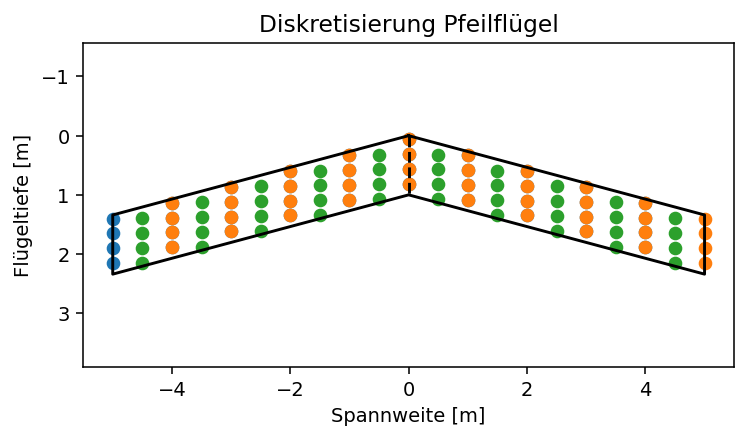

In [804]:
X_A, Y_A, X_B, Y_B, X_C, Y_C = compute_coords(s, phi, N, M)

points = pfeilfluegel(s, np.rad2deg(phi))
    
# Geometrie plotten
plt.figure(figsize=(6, 3))
plt.plot(points[:,0], points[:, 1], '-', color="black")
plt.scatter(Y_A, X_A)
plt.scatter(Y_B, X_B)
plt.scatter(Y_C, X_C)
plt.vlines(0, 0, 1, "black", "--")
plt.xlabel('Spannweite [m]')
plt.ylabel('Flügeltiefe [m]')
plt.title('Diskretisierung Pfeilflügel')
plt.axis('equal')
plt.gca().invert_yaxis()
plt.show()